In [2]:
# !pip install git+https://github.com/shuiruge/neural-ode.git@master

import numpy as np
import tensorflow as tf
from node.hopfield import ContinuousTimeHopfieldLayer
                           
# for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

tf.keras.backend.clear_session()


def pooling(x, size):
  # x shape: [None, width, height]
  x = tf.expand_dims(x, axis=-1)
  x = tf.image.resize(x, size)
  return x  # shape: [None, size[0], size[1], 1]


def process_data(X, y, image_size):
  X = pooling(X, image_size)
  X = X / 255.
  X = tf.where(X < 0.5, -1., 1.)
  X = tf.reshape(X, [-1, image_size[0] * image_size[1]])
  y = tf.one_hot(y, 10)
  return tf.cast(X, tf.float32), tf.cast(y, tf.float32)


def create_dataset(X, y, epochs=50, batch_size=512):
  dataset = tf.data.Dataset.from_tensor_slices((X, y))
  dataset = dataset.shuffle(1000).repeat(epochs).batch(batch_size)
  return dataset


def create_valid_dataset(X, y, n_samples=3000, batch_size=512):
  dataset = tf.data.Dataset.from_tensor_slices((X[:n_samples], y[:n_samples]))
  dataset = dataset.batch(batch_size)
  return dataset


def decompose_model(model):
  for i0, layer in enumerate(model.layers):
    if isinstance(layer, ContinuousTimeHopfieldLayer):
      break
  for i1, layer in enumerate(reversed(model.layers)):
    if isinstance(layer, ContinuousTimeHopfieldLayer):
      break
  return (tf.keras.Sequential(model.layers[:i0]),
        tf.keras.Sequential(model.layers[i0:-i1]),
        tf.keras.Sequential(model.layers[-i1:]))


# load and preprocess MNIST dataset

IMAGE_SIZE = (28, 28)

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, y_train = process_data(x_train, y_train, IMAGE_SIZE)

In [3]:
benchmark_model = tf.keras.Sequential([
  tf.keras.Input([IMAGE_SIZE[0] * IMAGE_SIZE[1]]),
  tf.keras.layers.LayerNormalization(),
  tf.keras.layers.Dense(1024),
  tf.keras.layers.LayerNormalization(),
  tf.keras.layers.Activation(tf.nn.relu),
  tf.keras.layers.Dense(1024),
  tf.keras.layers.LayerNormalization(),
  tf.keras.layers.Activation(tf.nn.relu),
  tf.keras.layers.Dense(1024),
  tf.keras.layers.LayerNormalization(),
  tf.keras.layers.Activation(tf.tanh),
  # tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax'),
])
benchmark_model.compile(
    loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
benchmark_model.fit(create_dataset(x_train, y_train))
benchmark_model.evaluate(create_valid_dataset(x_train, y_train))

6/6 [==============================] - 0s 3ms/step - loss: 5.4448e-05 - acc: 1.0000


[5.444816270028241e-05, 1.0]

Exame the noise effect:

In [4]:
FLIP_RATIO = 0.2

X = x_train[:1000]
targets = np.argmax(y_train[:1000], axis=1)
noised_X = np.where(np.random.random(size=X.shape) < FLIP_RATIO,
                    -X, X)
unoised_y = np.argmax(benchmark_model.predict(X), axis=1)
noised_y = np.argmax(benchmark_model.predict(noised_X), axis=1)

print('Noise effect (accuracy):',
      np.sum(unoised_y == targets) / targets.shape[0],
      '=>',
      np.sum(noised_y == targets) / targets.shape[0])

Noise effect (accuracy): 1.0 => 0.663


Extract the truncated model from the benchmark:

In [5]:
THRESHOLD = 0.1

# truncated model excluding the last classification layer

truncated_benchmark_model = tf.keras.Sequential(benchmark_model.layers[:-1])
unoised_z = truncated_benchmark_model.predict(X)
noised_z = truncated_benchmark_model.predict(noised_X)

z_flip_ratio = tf.reduce_mean(
    tf.where(tf.abs(unoised_z - noised_z) > THRESHOLD, 1., 0.))
print('Latent flip ratio:', z_flip_ratio.numpy())

Latent flip ratio: 0.6865


Follow the same process, but for Hopfield layer instead:

In [13]:
model = tf.keras.Sequential([
  tf.keras.Input([IMAGE_SIZE[0] * IMAGE_SIZE[1]]),
  tf.keras.layers.LayerNormalization(),
  tf.keras.layers.Dense(1024),
  tf.keras.layers.LayerNormalization(),
  tf.keras.layers.Activation(tf.nn.relu),
  tf.keras.layers.Dense(1024),
  tf.keras.layers.LayerNormalization(),
  tf.keras.layers.Activation(tf.nn.relu),
  tf.keras.layers.Dense(1024),
  tf.keras.layers.LayerNormalization(),
  tf.keras.layers.Activation(tf.tanh),

  # insert Hopfield layers herein
  ContinuousTimeHopfieldLayer(reg_factor=10, relax_tol=1e-3),
  ContinuousTimeHopfieldLayer(reg_factor=10, relax_tol=1e-3),

  tf.keras.layers.Dense(10, activation='softmax'),
])
model.compile(
    loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.fit(create_dataset(x_train, y_train, epochs=100, batch_size=128))
model.evaluate(create_valid_dataset(x_train[:1000], y_train[:1000]))

2/2 [==============================] - 0s 85ms/step - loss: 0.0129 - acc: 0.9980


[0.012898864224553108, 0.9980000257492065]

In [14]:
unoised_y = np.argmax(model.predict(X), axis=1)
noised_y = np.argmax(model.predict(noised_X), axis=1)

print('Noise effect (accuracy):',
      np.sum(unoised_y == targets) / targets.shape[0],
      '=>',
      np.sum(noised_y == targets) / targets.shape[0])

print('Relaxing period:')
for layer in model.layers:
  if isinstance(layer, ContinuousTimeHopfieldLayer):
    print(layer._stop_condition.relax_time.numpy())

Noise effect (accuracy): 0.998 => 0.643
Relaxing period:
16.136463
19.686222


In [17]:
# truncated model involving layers before Hopfield layers
encoding_part, hopfield_part, output_part = decompose_model(model)
unoised_z = encoding_part.predict(X)
noised_z = encoding_part.predict(noised_X)

z_flip_ratio = tf.reduce_mean(
    tf.where(tf.abs(unoised_z - noised_z) > THRESHOLD, 1., 0.))
print('Latent flip ratio (without Hopfield):', z_flip_ratio.numpy())


# truncated model also includes the Hopfield layers

unoised_z = hopfield_part.predict(unoised_z)
noised_z = hopfield_part.predict(noised_z)

z_flip_ratio = tf.reduce_mean(
    tf.where(tf.abs(unoised_z - noised_z) > THRESHOLD, 1., 0.))
print('Latent flip ratio (with Hopfield):', z_flip_ratio.numpy())

Latent flip ratio (without Hopfield): 0.010751953
Latent flip ratio (with Hopfield): 0.009118164


Temporal Conclusion:

1. Benchmark model is more stable for random flip perturbation in
the final accuracy.
1. However, the model with Hopfield layer is significantly more
stable in the last latent layer output (also in the layer just
before the first Hopfield layer).

In [94]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt


def plot_hist(tensor_like, name=None, show_shape=False):
  try:
    array = tensor_like.numpy()
  except AttributeError:
    array = tensor_like
  plt.hist(array.reshape([-1]), bins=50, density=True)
  if show_shape is True:
    name = '' if name is None else f'{name} | '
    name += f'shape: {array.shape}'
  if name is not None:
    plt.xlabel(name)
  plt.show()


def naked_output_part(x):
  global output_part
  W, b = output_part.trainable_variables
  return x @ W + b


def clip_small_value(x):
  return tf.where(tf.abs(x) > THRESHOLD, x, tf.zeros_like(x))

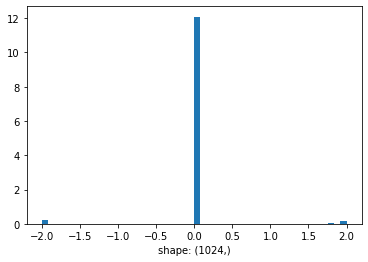

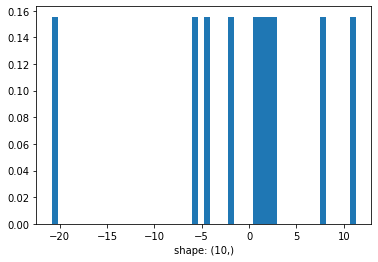

In [95]:
i = 2
plot_hist(clip_small_value(noised_z - unoised_z)[i], show_shape=True)
plot_hist(clip_small_value(naked_output_part(noised_z) - naked_output_part(unoised_z))[i], show_shape=True)

**So, the output layer (before activation) is sensitive to some dimension. This causes the observed instability.**

TODO:

In [ ]:
import tensorflow as tf
from node.core import get_node_function
from node.solvers.runge_kutta import RKF56Solver


class NodeLayer(tf.keras.layers.Layer):

  def __init__(self, hidden_units, t, **kwargs):
    super().__init__(**kwargs)
    self.hidden_units = hidden_units
    self.t = tf.convert_to_tensor(float(t))

  def build(self, input_shape):
    print(input_shape)
    layers = [tf.keras.Input(input_shape[1:])]
    for n in self.hidden_units:
      layers += [
        tf.keras.layers.Dense(n),
        tf.keras.layers.LayerNormalization(),
        tf.keras.layers.Activation(tf.nn.relu),
      ]
    layers.append(tf.keras.layers.Dense(input_shape[-1]))
    static_pvf = tf.keras.Sequential(layers)
    dynamics = lambda t, x: static_pvf(x)
    solver = RKF56Solver(dt=1e-1, tol=1e-3, min_dt=1e-2)
    node_fn = get_node_function(solver, dynamics)

    def solve_fn(x):
      return node_fn(tf.constant(0.), self.t, x)

    self._solve_fn = solve_fn

    super().build(input_shape)

  def call(self, inputs):
    return self._solve_fn(inputs)

In [ ]:
# model_2 = tf.keras.Sequential([
#   tf.keras.Input([IMAGE_SIZE[0] * IMAGE_SIZE[1]]),
#   tf.keras.layers.LayerNormalization(),
#   tf.keras.layers.Dense(128),
#   tf.keras.layers.LayerNormalization(),
#   NodeLayer([256], 1.),
#   tf.keras.layers.Activation(tf.tanh),

#   # insert Hopfield layers herein
#   # ContinuousTimeHopfieldLayer(reg_factor=10, relax_tol=1e-3),
#   # ContinuousTimeHopfieldLayer(reg_factor=10, relax_tol=1e-3),

#   tf.keras.layers.Dense(10, activation='softmax'),
# ])
# model_2.compile(
#     loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
# model_2.fit(create_dataset(x_train, y_train, epochs=50))
# model_2.evaluate(create_valid_dataset(x_train[:1000], y_train[:1000]))